In [1]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
model = pints.toy.FitzhughNagumoModel()

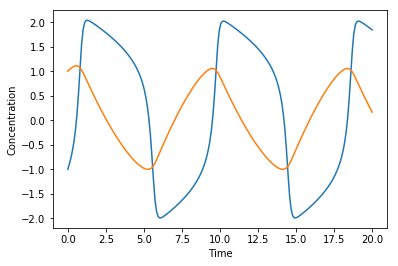

In [2]:
# Run the same simulation using our new model wrapper
times = np.linspace(0, 20, 200)
values = model.simulate([0.1,0.1,3], times)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)


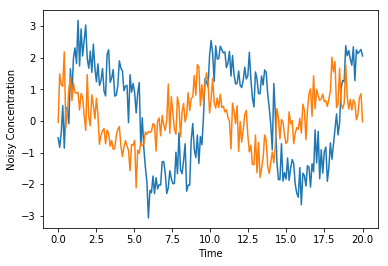

In [3]:
# Define the 'true' parameters
true_parameters = [0.1, 0.1, 3.]

# Run a simulation to get test data
values = model.simulate(true_parameters, times)

# Add some noise
sigma = 0.5
values = values + np.random.randn(values.shape[0],values.shape[1])*sigma

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Noisy Concentration')
plt.plot(times, values)

In [4]:
# Create an object with links to the model and time series
problem = pints.MultiSeriesProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

In [ ]:
boundaries = pints.Boundaries([0., 0., 0.], [10., 10., 10.])

# Select a starting point
x0 = [1, 1, 1]

# Perform an optimization
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries)
print('Score at true solution:')
print(score(true_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values, alpha=0.5, label='noisy signal')
plt.plot(times, problem.evaluate(found_parameters), label='recovered signal')
plt.legend()
plt.show()

In [9]:
log_likelihood = pints.UnknownMultivariateNoiseLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0],
    [2, 2, 10, 2, 2]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [10]:
found_parameters = np.hstack((found_parameters, sigma, sigma))

In [11]:
# Choose starting points for 3 mcmc chains
xs = [
    found_parameters * 1.1,
    found_parameters * 0.9,
    found_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_adaptation_free_iterations(1000)

# Disable verbose mode
#mcmc.set_log_to_screen(False)

True

In [ ]:
# Run!
print('Running...')
chains = mcmc.run()
print('Done!')


Running...
Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0.5       0.5        0:00.1
2     9      0         0.333     0.667      0:00.2
3     12     0         0.5       0.5        0:00.2
20    63     0.286     0.19      0.238      0:01.0
40    123    0.171     0.146     0.195122   0:02.0
60    183    0.131     0.0984    0.18       0:03.0
80    243    0.111     0.0864    0.148      0:03.9
100   303    0.119     0.0693    0.129      0:05.0
120   363    0.107438  0.0579    0.107438   0:05.9
140   423    0.0993    0.0496    0.0922     0:06.8
160   483    0.0932    0.0435    0.087      0:07.7
180   543    0.0884    0.0442    0.0829     0:08.8
200   603    0.0796    0.039801  0.0846     0:09.8
220   663    0.0724    0.0362    0.0769     0:10.8
240   723    0.0664    0.0332    0.0705     0:11.8
260   783    0.0613    0.0307    0.0651   

In [ ]:
import pints.plot
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()